In [1]:
import sys
sys.path.append('..')
from Comms_System import Comms_System, SNR_plot
import numpy as np
import matplotlib.pyplot as plt
from ML_components import load_params
from Network import NeuralNetwork
import scipy
from scipy.signal import TransferFunction, bode
import torch
from filters import butter_lowpass
print('Yo, welcome to Main CS')

Yo, welcome to Main CS


## Automatic Tests

In [3]:
#symbol_set = [7, 5, 3, 1, -1, -3, -5, -7] # all symbols that we use
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 10000
symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
SNR = 6.5


# can never not normalize and not use gain. Either one or both.
decisions = CS.transmission(SNRdb=SNR, mode='euclidean', v=True)

print("Accuracy:", 1 - CS.evaluate(decisions)[1])

2.976913926996318
Accuracy: 0.7363999999999999


### Manual Test

In [ ]:
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 1000

symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
sigma = 2

# calibrate
gain_factor = np.max(np.convolve(CS.h, CS.h))

# upsample symbol sequence and filter it on transmission side
upsampled = CS.upsample()
Tx = np.convolve(upsampled, CS.h)

# Transmit the filtered signal (i.e. add noise)
Tx = Tx + np.random.normal(0.0, sigma, Tx.shape)  # add gaussian noise

# Filter on receiver side
Rx = np.convolve(Tx, CS.h)#/np.sqrt(gain_factor)

# Downsample the signal on the receiver side
downsampled = CS.downsample(Rx)/gain_factor

# Decision-making using new_values
decisions = CS.decision_making(downsampled, False)

1 - CS.evaluate(decisions)[1]

### Manual Test with normalization of signal instead of gain_factor

In [ ]:
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 1000

symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
symbol_seq_power = np.mean(np.square(symbol_seq))
SNR = 10
sigma = CS.SNRdb_to_sigma(SNR, 8, use_gain=False)
print(sigma)

# upsample symbol sequence and filter it on transmission side
upsampled = CS.upsample(v=False)
Tx = np.convolve(upsampled, CS.h)

# Normalize signal with RMS
Tx = Tx / np.sqrt(np.mean(np.square(Tx)))

# Transmit the filtered signal (i.e. add noise)
Tx = Tx + np.random.normal(0.0, sigma, Tx.shape)  # add gaussian noise

# Filter on receiver side
Rx = np.convolve(Tx, CS.h)

# Normalize received signal with RMS * squareroot of symbol seq power?
Rx = (Rx / np.sqrt(np.mean(np.square(Rx)))) * np.sqrt(symbol_seq_power)

# Downsample the signal on the receiver side
downsampled = CS.downsample(Rx)

# Decision-making using new_values
decisions = CS.decision_making(downsampled, False)

1 - CS.evaluate(decisions)[1]

## Display filter

In [ ]:
m = 8
betas = [0, 0.35, 0.7, 1]
plt.figure(figsize=(13,8))
plt.title('Root Raised Cosine', fontsize=24)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
z = np.zeros(len(CS.h))
for beta in betas:
    CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=beta)
    #f = np.fft.fft(CS.h)
    plt.plot(CS.h)
plt.grid(True)
plt.legend(betas, fontsize=12)
plt.show()

plt.figure(figsize=(13,8))
plt.title('Raised Cosine', fontsize=24)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
z = np.zeros(len(CS.h))
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
plt.stem(np.convolve(CS.h, CS.h))
plt.grid(True)
plt.show()


plt.figure(figsize=(13,8))
plt.title('Root Raised Cosine (Frequency Spectrum)', fontsize=24)
plt.xlabel('Frequency', fontsize=20)
plt.ylabel('Magnitude (Energy)', fontsize=20)
for beta in betas:
    CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=beta)
    plt.magnitude_spectrum(CS.h, CS.m, sides='twosided')
plt.grid(True)
plt.legend(betas, fontsize=12)
plt.show()

plt.figure(figsize=(13,8))
plt.title('Raised Cosine (Frequency Spectrum)', fontsize=24)
plt.xlabel('Frequency', fontsize=20)
plt.ylabel('Magnitude (Energy)', fontsize=20)
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
plt.magnitude_spectrum(np.convolve(CS.h, CS.h), CS.m, sides='twosided', color='C1')
plt.grid(True)
plt.show()

____

# Evaluation of pretrained Decision Making models

In [ ]:
for i in range(5):

    symbol_set = [3, 1, -1, -3] # all symbols that we use
    num_symbols = 10000
    symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
    m = 8
    CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m)
    SNRdb = 16    
    
    euclid_decs, NN_decs, block_decs, network_decs, joint_decs = CS.transmit_all(SNRdb, joint_cutoff=0.675)
    

    print('Euclidean Error Rate: {}%'.format((CS.evaluate(euclid_decs)[1]*100).round(2)))
    print('NN Error Rate: {}%'.format((CS.evaluate(euclid_decs)[1]*100).round(2)))
    print('Block Error Rate: {}%'.format((CS.evaluate(block_decs)[1]*100).round(2)))
    print('Receiver Network Error Rate: {}%'.format((CS.evaluate(network_decs)[1]*100).round(2)))
    print('Joint Sender-Receiver Network Error Rate: {}%'.format((CS.evaluate(joint_decs)[1]*100).round(2)))
    print()

### SNR Calculations

In [18]:
SNRdbs, euclid_error_rates, network_error_rates, NN_error_rates, block_error_rates, \
joint_error_rates, error_theory = SNR_plot(num_symbols=20000, joint_cutoff=0.675)

Avg symbol energy 4.98
gain 7.997651076371556


In [ ]:
plt.figure(figsize=(13,8))
#plt.title('Joint Networks Noise Plot with cutoff  ' r'$\frac{1}{2}$', fontsize=24)
#plt.title('Noise Plot')
plt.xlabel('SNR (dB)', fontsize=20)
plt.ylabel('$P_e$', fontsize=24)
num = 0
plt.semilogy(SNRdbs[num:], euclid_error_rates[num:], alpha=1, linewidth=3, label='Euclidean')
#plt.semilogy(SNRdbs[num:], NN_error_rates[num:], label='NN Dec Maker')
#plt.semilogy(SNRdbs[num:], block_error_rates[num:], label='Block')
plt.semilogy(SNRdbs[num:], network_error_rates[num:], alpha=1, linewidth=3, label='Receiver Network')
#plt.semilogy(SNRdbs[num:], joint_error_rates[num:], alpha=1, linewidth=3, label='Joint Networks')
#plt.semilogy(SNRdbs[num:], error_theory[num:], alpha=0.75, linewidth=3, label='Theory')
plt.legend(fontsize=16)
plt.show()

In [ ]:
er_for_sigma3 = 1.5 * (1 - scipy.stats.norm.cdf(np.sqrt(8/(3**2))))
er_for_sigma2 = 1.5 * (1 - scipy.stats.norm.cdf(np.sqrt(8/(2**2))))
er_for_sigma1 = 1.5 * (1 - scipy.stats.norm.cdf(np.sqrt(8/(1**2))))
print(1-er_for_sigma1, 1-er_for_sigma2, 1-er_for_sigma3)

# Inspect Decision Boundaries for NN Decision Making

In [ ]:
weights, biases, sizes = load_params('../Weights/decision_making_weights.npz',
                                         '../Weights/decision_making_biases.npz')
NN = NeuralNetwork(sizes, startweights=weights, startbiases=biases,
                           type='classification', afunc='relu')
classes = np.array(symbol_set)

## Plot 1

In [ ]:
test_seq = np.linspace(-4, 4, 40)
test_seq = np.array(test_seq, ndmin=2).T
yhat_onehot = NN.feedforward(test_seq)
print(yhat_onehot.shape)


plt.figure(figsize=(13,8))
#plt.title('Decision Boundaries', fontsize=24)
for i in range(yhat_onehot.shape[1]):
    plt.plot(test_seq, yhat_onehot[:,i], '-x')
#plt.axvline(x=-2, color='black')
#plt.axvline(x=0, color='black')
#plt.axvline(x=2, color='black')
plt.xlabel('Input', fontsize=20)
plt.ylabel('Probability of choosing', fontsize=20)
plt.legend(symbol_set + ['Euclidean Boundaries'], fontsize=14)
plt.show()
#plt.savefig('Boundaries', bbox_inches='tight', transparent=True)

## Plot 2

In [ ]:
classes = np.array(symbol_set)
test_seq = np.linspace(-4, 4+1, 100)
test_seq = np.array(test_seq, ndmin=2).T

yhat_idx = NN.feedforward(test_seq).argmax(axis=1)
yhat = classes[yhat_idx]
euclid_decisions = CS.decision_making(test_seq)


num = len(test_seq)
plt.figure(figsize=(13,8))
plt.xlabel('Sample Value (input)', fontsize=20)
plt.ylabel('Decided value (output)', fontsize=20)
plt.plot(test_seq[:num], euclid_decisions[:num], '-bx', alpha=1, label='Euclidean')
plt.plot(test_seq[:num], yhat[:num], '-rx', alpha=1, label='Neural Network')
plt.legend(fontsize=14)
plt.show()

# Inspect Decision Boundaries for RX_Network

In [ ]:
test_seq_ = np.linspace(-4, 4, 400)
test_seq = torch.Tensor(test_seq_)
x = test_seq.view(1, 1, -1)
yhat = net(x)[0].T
softmax = torch.nn.Softmax(dim=1)
probs = softmax(yhat).detach().numpy()

plt.figure(figsize=(13,8))
#plt.title('Decision Boundaries', fontsize=24)
for i in range(probs.shape[1]):
    plt.plot(probs[:,i], '-x')
#plt.axvline(x=-2, color='black')
#plt.axvline(x=0, color='black')
#plt.axvline(x=2, color='black')
plt.xlabel('Input', fontsize=20)
plt.ylabel('Probability of choosing', fontsize=20)
plt.legend(symbol_set + ['Euclidean Boundaries'], fontsize=14)
plt.show()

# Inspect effect of filtering with learned filters versus with RRC

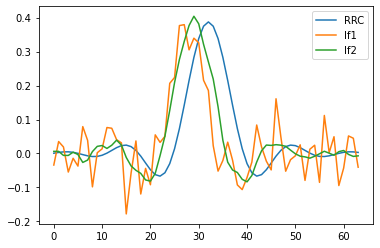

1.9997063629907712


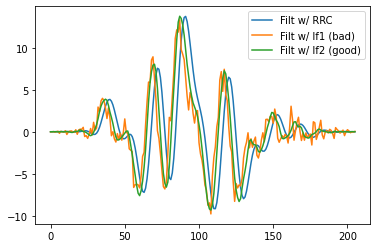

In [4]:
net1 = torch.load('../Conv1DModels/best_conv_model2')
net2 = torch.load('../Conv1DModels/RX_network')
lf1 = list(net1.parameters())[0].detach()[0][0].numpy()
lf2 = list(net2.parameters())[0].detach()[0][0].numpy()
h = CS.h / np.sqrt(np.sum(np.square(CS.h)))
lf1 /= np.sqrt(np.sum(np.square(lf1)))
lf2 /= np.sqrt(np.sum(np.square(lf2)))
plt.plot(h, label='RRC')
plt.plot(lf1, label='lf1')
plt.plot(lf2, label='lf2')
plt.legend()
plt.show()

symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 10
symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
SNR = 10
sigma = CS.SNRdb_to_sigma(SNRdb=SNR, energy=5, use_gain=True)
print(sigma)

up = CS.upsample()
Tx = np.convolve(up, CS.h)
#Tx = Tx / np.sqrt(np.mean(np.square(Tx)))
Tx = Tx + np.random.normal(0.0, sigma, Tx.shape)  # add gaussian noise

# Filter on receiver side with learned filter
Rx1 = np.convolve(Tx, h)
plt.plot(Rx1, label='Filt w/ RRC')
Rx2 = np.convolve(Tx, lf1)
plt.plot(Rx2, label='Filt w/ lf1 (bad)')
Rx3 = np.convolve(Tx, lf2)
plt.plot(Rx3, label='Filt w/ lf2 (good)')
plt.legend()
plt.show()

# Plot Lowpass Filters

In [ ]:
# Butterworth

cutoff = 0.675
b_10, a_10 = butter_lowpass(cutoff_freq=cutoff, sampling_rate=CS.m, order=10)
b_4, a_4 = butter_lowpass(cutoff_freq=cutoff, sampling_rate=CS.m, order=4)
w_range = np.linspace(-4, 4, 10000)
w_10, m_10, _ = TransferFunction(b_10, a_10/7.3, dt=CS.m).bode(n=10000, w=w_range)
#w_10, m_10, _ = TransferFunction(b_10, a_10, dt=CS.m).bode(n=10000, w=w_range)
w_4, m_4, _ = TransferFunction(b_4, a_4, dt=CS.m).bode(n=10000, w=w_range)


# Raised Cosine
h = CS.h / max(CS.h)
raised_cosine = np.convolve(CS.h, CS.h)
raised_cosine /= max(raised_cosine)
w_raised, m_raised, _ = TransferFunction(raised_cosine, 1, dt=CS.m).bode(n=10000, w=w_range) #65

# Root-Raised Cosine
w_rrc, m_rrc, _ = TransferFunction(h, 1, dt=CS.m).bode(n=10000, w=w_range) # 8

# Ideal Lowpass Filter
w10 = w_10*10
idx1 = np.where(w10.round(3) == -cutoff)[0][0]
idx2 = np.where(w10.round(3) == cutoff)[0][0]
ideal = np.ones(len(w10)) * -70
ideal[idx1: idx2+1] = 17.34 # 0

plt.figure(figsize=(13,8))
plt.plot(w10, ideal, linewidth=3, color='C2', label='Ideal Lowpass Filter') # ideal
#plt.plot(w_4*10, m_4, linewidth=3, color='C4', alpha=0.5, label='Butterworth (order=4)') # butterworth order 4
plt.plot(w_10*10, m_10, linewidth=3, color='C0', label='Butterworth (order=10)') # butterworth order 10
plt.plot(w_rrc*10, m_rrc, linewidth=3, color='C1', label='RRC (rolloff=0.35)') # rrc
plt.plot(w_raised*10, m_raised, linewidth=3, color='C5', label='Raised Cosine (rolloff=0.35)')
plt.title('Filters Frequency Response (cutoff = '+str(cutoff)+'Hz)', fontsize=20)
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Magnitude [dB]', fontsize=16)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True)
plt.ylim([-5, 20])
plt.xlim([-2, 2])
plt.show()

##### Want to time something? Use following code stump

In [ ]:
# %%timeit -o -r 5